## DATASET

In [1]:
from dataset_creation import getDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train_blurred, x_train), (x_test_blurred, x_test)  = getDataset()

Resolution $32*32$

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# The dataset is already normalized
x_train[0].min(), x_train[0].max()

(0.0, 1.0)

Let's see some examples

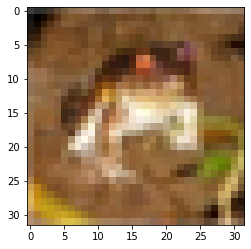

In [ ]:
plt.imshow(x_train[0])

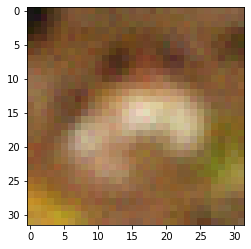

In [ ]:
plt.imshow(x_train_blurred[0])

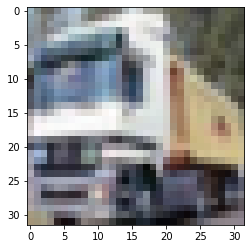

In [ ]:
plt.imshow(x_train[1])

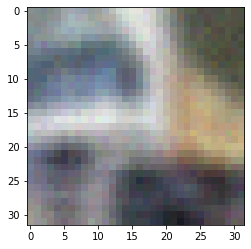

In [ ]:
plt.imshow(x_train_blurred[1])

## MODEL

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPool2D, concatenate
from tensorflow.keras import Model

Compression from $32*32*3=3072$ to $4*4*256=4096$. No compression.

In [4]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    x = Input(shape=input_shape)

    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)
        
    # Output
    y = Conv2D(3, 1, activation='sigmoid')(h)
    return Model(x, y)

In [5]:
unet = build_unet((32, 32, 3))

In [9]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['re_lu[0][0]']                  
                                                                                              

## TRAINING

In [9]:
from tensorflow.keras.optimizers import Adam

In [11]:
unet.compile(optimizer=Adam(), loss='mse')

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('UNet.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [13]:
hist = unet.fit(x_train_blurred, x_train, epochs=15, validation_split=0.2, callbacks=[callback_checkpoint])

Epoch 1/15
1250/1250 [==============================] - 31s 15ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 2/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/15
1250/1250 [==============================] - 18s 14m

In [6]:
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

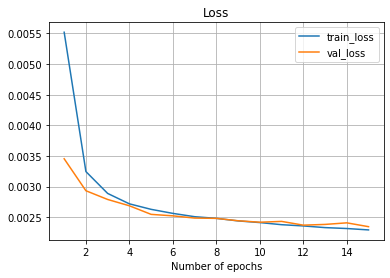

In [15]:
plot_history(hist)

Final score on the test set. Better than Convolutional autoencoder.

In [16]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(x_test, unet.predict(x_test_blurred)).numpy()

0.0023517446

## MORE TRAINING

In [13]:
unet = build_unet((32, 32, 3))

In [14]:
unet.compile(optimizer=Adam(), loss='mse')

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
callback_checkpoint = ModelCheckpoint('UNet.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 
reduce_lr_callback = ReduceLROnPlateau(patiente=3)

In [16]:
hist = unet.fit(x_train_blurred, x_train, epochs=50, batch_size=32, validation_split=0.2, 
                callbacks=[callback_checkpoint,reduce_lr_callback])

Epoch 1/50
1250/1250 [==============================] - 19s 14ms/step - loss: 0.0053 - val_loss: 0.0034 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0032 - val_loss: 0.0030 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0029 - val_loss: 0.0028 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0027 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 8/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 9/50
1250/1250 [==============================] - 18s 14ms

In [17]:
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

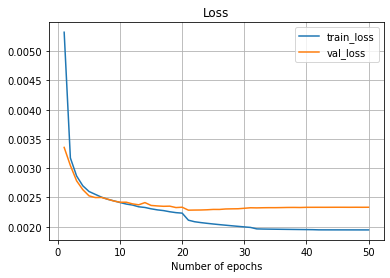

In [18]:
plot_history(hist)

Final score on the test set. Better than before.

In [20]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(x_test, unet.predict(x_test_blurred)).numpy()

0.0023396695

## DATA AUGMENTATION

In [21]:
import tensorflow as tf
import random

In [22]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=32
#augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=x_train_blurred, y=x_train, batch_size=BATCH_SIZE, augmentations=augmentation_lst)

In [23]:
unet_augm = build_unet((32,32,3))

In [24]:
unet_augm.compile(optimizer=Adam(), loss='mse')

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
callback_checkpoint = ModelCheckpoint('UNet_Augmentation.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 
reduce_lr_callback = ReduceLROnPlateau(patiente=3)

In [26]:
steps_per_epoch_train = len(x_train)//BATCH_SIZE

In [15]:
hist = unet_augm.fit(image_generator_train, epochs=50, validation_data=(x_test_blurred,x_test),
                     callbacks=[callback_checkpoint,reduce_lr_callback],
                     steps_per_epoch=steps_per_epoch_train)

Epoch 1/50
1562/1562 [==============================] - 38s 16ms/step - loss: 0.0050 - val_loss: 0.0035 - lr: 0.0010
Epoch 2/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0031 - val_loss: 0.0028 - lr: 0.0010
Epoch 3/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0028 - val_loss: 0.0027 - lr: 0.0010
Epoch 4/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0027 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/50
1562/1562 [==============================] - 24s 16ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/50
1562/1562 [==============================] - 25s 16ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 8/50
1562/1562 [==============================] - 24s 16ms/step - loss: 0.0025 - val_loss: 0.0024 - lr: 0.0010
Epoch 9/50
1562/1562 [==============================] - 24s 16ms

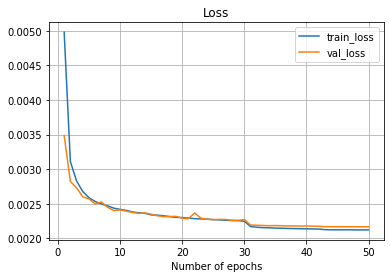

In [17]:
plot_history(hist)

Final score on the test set. Better than before.

In [18]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(x_test, unet_augm.predict(x_test_blurred)).numpy()

0.0021673732

Let's try again, with a different `ReduceLROnPlateau` strategy

In [19]:
unet_augm = build_unet((32,32,3))

In [20]:
unet_augm.compile(optimizer=Adam(), loss='mse')

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
callback_checkpoint = ModelCheckpoint('UNet_Augmentation.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')

In [22]:
steps_per_epoch_train = len(x_train)//BATCH_SIZE

In [23]:
hist = unet_augm.fit(image_generator_train, epochs=50, validation_data=(x_test_blurred,x_test),
                     callbacks=[callback_checkpoint,reduce_lr_callback],
                     steps_per_epoch=steps_per_epoch_train)

Epoch 1/50
1562/1562 [==============================] - 32s 19ms/step - loss: 0.0051 - val_loss: 0.0034 - lr: 0.0010
Epoch 2/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0032 - val_loss: 0.0029 - lr: 0.0010
Epoch 3/50
1562/1562 [==============================] - 23s 15ms/step - loss: 0.0028 - val_loss: 0.0027 - lr: 0.0010
Epoch 4/50
1562/1562 [==============================] - 23s 15ms/step - loss: 0.0027 - val_loss: 0.0026 - lr: 0.0010
Epoch 5/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/50
1562/1562 [==============================] - ETA: 0s - loss: 0.0025
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
1562/1562 [==============================] - 25s 16ms/step - loss: 0.0025 - val_loss: 0.0027 - lr: 0.0010
Epoch 7/50
1562/1562 [==============================] - 24s 15ms/step - loss: 0.0025 - val_loss: 0.0024 - lr: 7.5000e-04
Epoch 8/50
1562/1562 [===========

In [24]:
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

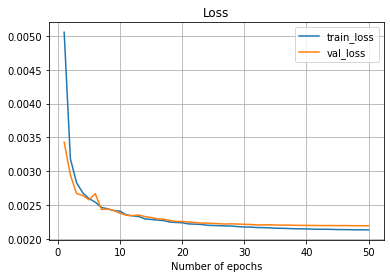

In [25]:
plot_history(hist)

In [26]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(x_test, unet_augm.predict(x_test_blurred)).numpy()

0.0021954281